<a href="https://colab.research.google.com/github/Yashmaini30/Tomato_Leaf-_Disease_Detection/blob/main/Copy_of_Tomato_Leaf_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tomatoleaf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F619181%2F1105687%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240913%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240913T043505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e4f8c415be6f4a82a103ad882eaa1415571190b0dfc95ab615aec3242dd75fc827e1a89211c0b1aaee13d49783427952d1e20e5bda2a6347a28d41ab060c149175b85928a9342741cd53311b6f6f5f6a1e8b0e3d229c5a225874c977ad842d3e960769ba0fa6e93faa5cc1c2144d925bb04f80e6099a2217ffa6a3daf8c8dabcd898cea0f4fe2dbd2db9881960078ed34dce13524bba6a3cbe2863cdb02c7e884e6e9f9c2623ceade6cecd1f9b968310cb61220e6599e923e213b53a14346d977c7bfa287f2c89b461b4506713149c99438e37ab34fe8459773372ca7acf27b62f2a80ccd03a62442c6505ddc179301669a854f6a7d744ddcd4428e637ce53a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 187559775 bytes downloaded
Downloaded and uncompressed: tomatoleaf
Data source import complete.


In [ ]:
!pip install keras-tuner

In [ ]:
import os
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception  # Pre-trained models for transfer learning
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch


<ipython-input-3-3e0bd1ffa5e5>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

Found 10000 files belonging to 10 classes.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 1000 files belonging to 10 classes.


In [ ]:
import os

def count_images_in_directory(base_path):
    # Get a list of subdirectories (each subdirectory represents a label)
    labels = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Create a dictionary to store label counts
    label_counts = {}

    # Loop over each label and count the number of images in each directory
    for label in labels:
        label_path = os.path.join(base_path, label)
        image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]
        label_counts[label] = len(image_files)

    return label_counts

# Paths to the training and validation directories
train_path = '/kaggle/input/tomatoleaf/tomato/train'
val_path = '/kaggle/input/tomatoleaf/tomato/val'

# Get image counts for both directories
train_counts = count_images_in_directory(train_path)
val_counts = count_images_in_directory(val_path)

# Display the counts for each label in both train and val datasets
for label in train_counts:
    train_count = train_counts.get(label, 0)
    val_count = val_counts.get(label, 0)
    print(f"Label: {label}, Train Count: {train_count}, Val Count: {val_count}")


Label: Tomato___healthy, Train Count: 1000, Val Count: 100
Label: Tomato___Bacterial_spot, Train Count: 1000, Val Count: 100
Label: Tomato___Early_blight, Train Count: 1000, Val Count: 100
Label: Tomato___Septoria_leaf_spot, Train Count: 1000, Val Count: 100
Label: Tomato___Tomato_mosaic_virus, Train Count: 1000, Val Count: 100
Label: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Train Count: 1000, Val Count: 100
Label: Tomato___Target_Spot, Train Count: 1000, Val Count: 100
Label: Tomato___Leaf_Mold, Train Count: 1000, Val Count: 100
Label: Tomato___Spider_mites Two-spotted_spider_mite, Train Count: 1000, Val Count: 100
Label: Tomato___Late_blight, Train Count: 1000, Val Count: 100


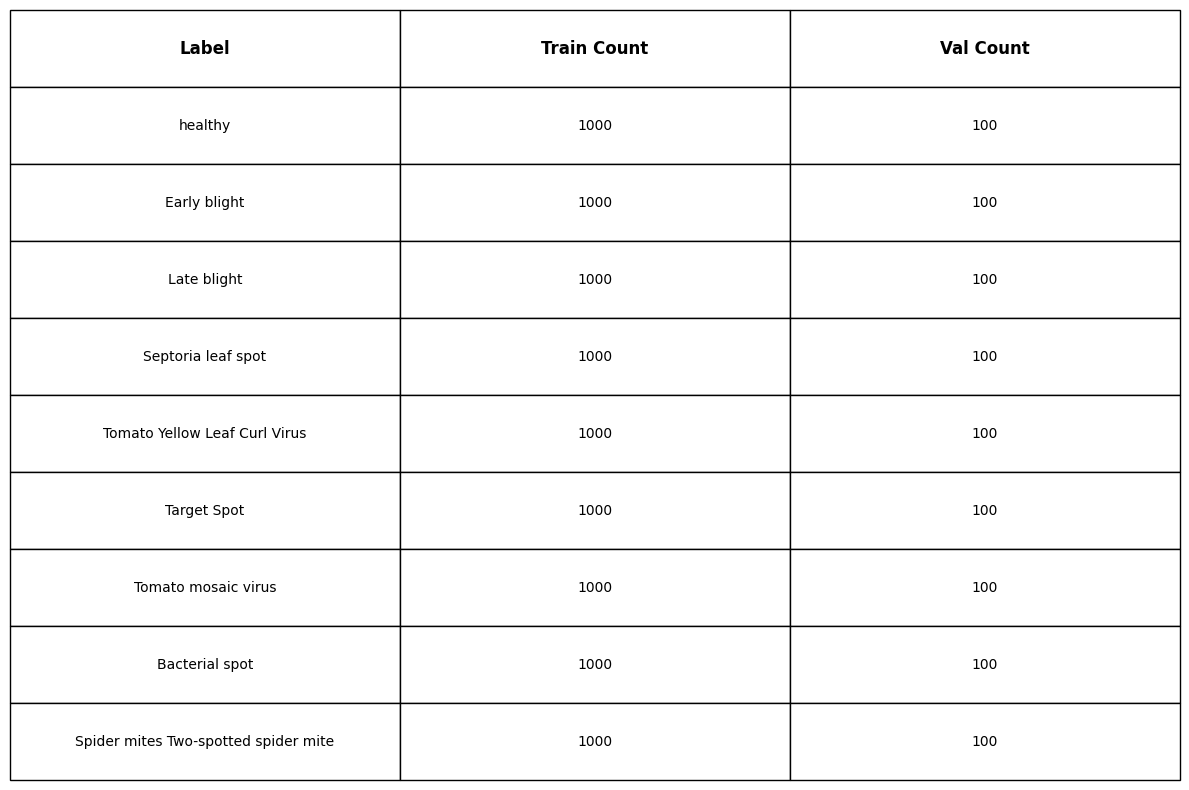

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from previous calculations
train_counts = {'Tomato___healthy': 1000, 'Tomato___Early_blight': 1000, 'Tomato___Late_blight': 1000, 'Tomato___Septoria_leaf_spot': 1000, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1000, 'Tomato___Target_Spot': 1000, 'Tomato___Tomato_mosaic_virus': 1000, 'Tomato___Bacterial_spot': 1000, 'Tomato___Spider_mites Two-spotted_spider_mite': 1000}
val_counts = {'Tomato___healthy': 100, 'Tomato___Early_blight': 100, 'Tomato___Late_blight': 100, 'Tomato___Septoria_leaf_spot': 100, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 100, 'Tomato___Target_Spot': 100, 'Tomato___Tomato_mosaic_virus': 100, 'Tomato___Bacterial_spot': 100, 'Tomato___Spider_mites Two-spotted_spider_mite': 100}

# Function to clean up labels
def clean_label(label):
    return label.replace('Tomato___', '').replace('_', ' ')

# Clean labels
cleaned_labels = [clean_label(label) for label in train_counts.keys()]

# Create a DataFrame for the table
df = pd.DataFrame({
    'Label': cleaned_labels,
    'Train Count': [train_counts[label] for label in train_counts],
    'Val Count': [val_counts[label] for label in val_counts]
})

# Plot the table
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)

# Make headings bolder
for (i, j), cell in table._cells.items():
    if i == 0:  # This checks if the row is the header
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')

table.scale(1.2, 1.2)

# Save and show the plot
plt.tight_layout()
plt.savefig('/kaggle/working/label_counts_table.png', dpi=300)
plt.show()


In [ ]:
labels=[
"Tomato___Late_blight",
"Tomato___healthy",
"Tomato___Early_blight",
"Tomato___Septoria_leaf_spot",
"Tomato___Tomato_Yellow_Leaf_Curl_Virus",
"Tomato___Bacterial_spot",
"Tomato___Target_Spot",
"Tomato___Tomato_mosaic_virus",
"Tomato___Leaf_Mold",
"Tomato___Spider_mites Two-spotted_spider_mite",
]

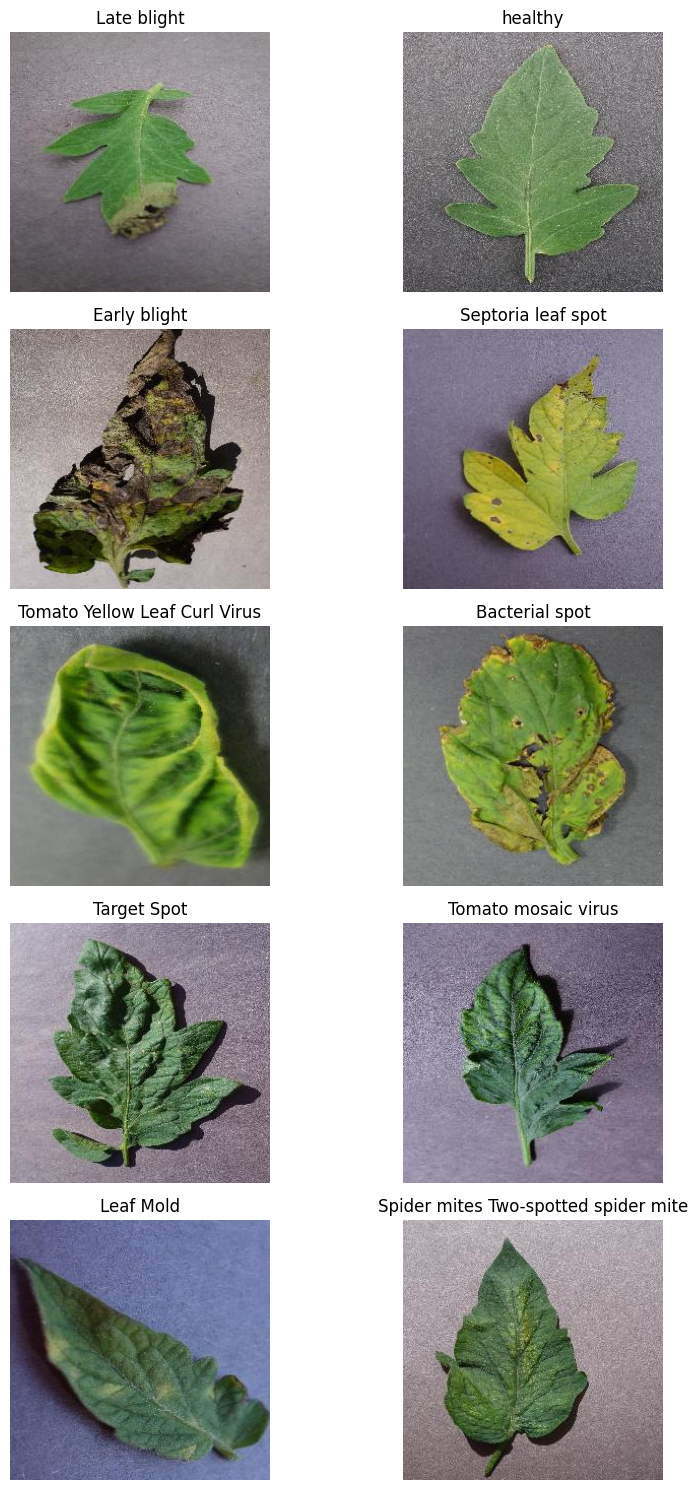

In [ ]:
# Path to the directory containing images
base_path = "/kaggle/input/tomatoleaf/tomato/train/"

# Create a figure for displaying 5x2 images
fig, axs = plt.subplots(5, 2, figsize=(10, 15))  # 5 rows, 2 columns

# Loop over the labels and display one image per label
for i, label in enumerate(labels):
    # Get the directory for the current label
    label_path = os.path.join(base_path, label)

    # Get a list of all image file names in the label directory
    image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]

    # Select the first image in the directory
    image_file = image_files[0]

    # Load and display the image
    img_path = os.path.join(label_path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 2, i % 2]  # Adjust to 5 rows and 2 columns
    ax.imshow(img)
    ax.axis('off')

    display_label = label.replace("Tomato___", "").replace('_', ' ')
    ax.set_title(display_label)

# Adjust the layout and space between subplots
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.1, wspace=0.1)
plt.tight_layout()

# Save the figure with DPI of 300 for high quality
plt.savefig('tomato_leaf_grid.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=0)]
)

val_accuracy_cnn = history_cnn.history['val_accuracy']

val_loss_cnn = history_cnn.history['val_loss']

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.3635 - loss: 1.7868 - val_accuracy: 0.6650 - val_loss: 0.9798
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.6733 - loss: 0.9739 - val_accuracy: 0.8080 - val_loss: 0.5844


In [ ]:
effiecientNet_base = EfficientNetB4(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)

effiecientNet_base.trainable = False

model_efficientNet = Sequential()
model_efficientNet.add(effiecientNet_base)
model_efficientNet.add(BatchNormalization())
model_efficientNet.add(Dense(256, activation='relu'))
model_efficientNet.add(Dropout(0.35))
model_efficientNet.add(BatchNormalization())
model_efficientNet.add(Dense(120, activation='relu'))
model_efficientNet.add(Dense(10, activation='softmax'))

model_efficientNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_efficientNet = model_cnn.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=0)]
)

val_accuracy_efficientNet = history_efficientNet.history['val_accuracy']

val_loss_efficientNet = history_efficientNet.history['val_loss']

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.7771 - loss: 0.6554 - val_accuracy: 0.8430 - val_loss: 0.4570
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8156 - loss: 0.5407 - val_accuracy: 0.8610 - val_loss: 0.4679


In [ ]:
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg'
)

# Freeze the DenseNet base
densenet_base.trainable = False

# Build the model
model_denseNet = Sequential()
model_denseNet.add(densenet_base)
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(256, activation='relu'))
model_denseNet.add(Dropout(0.35))
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(120, activation='relu'))
model_denseNet.add(Dense(10, activation='softmax'))

# Compile the model
model_denseNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_densenet = model_denseNet.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=0)]
)
val_accuracy_densenet = history_densenet.history['val_accuracy']

val_loss_densenet = history_densenet.history['val_loss']


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 208ms/step - accuracy: 0.3382 - loss: 1.9818 - val_accuracy: 0.7560 - val_loss: 0.9305
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.7527 - loss: 0.7937 - val_accuracy: 0.8450 - val_loss: 0.5138


In [ ]:
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg'
)

# Freeze the Xception base
xception_base.trainable = False

# Build the model
model_xception = Sequential()
model_xception.add(xception_base)
model_xception.add(BatchNormalization())
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.35))
model_xception.add(BatchNormalization())
model_xception.add(Dense(120, activation='relu'))
model_xception.add(Dense(10, activation='softmax'))

# Compile the model
model_xception.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_xception = model_xception.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=0)]
)

val_accuracy_xception = history_xception.history['val_accuracy']

val_loss_xception = history_xception.history['val_loss']

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 242ms/step - accuracy: 0.3538 - loss: 1.9416 - val_accuracy: 0.7110 - val_loss: 1.0998
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.7101 - loss: 0.9109 - val_accuracy: 0.7910 - val_loss: 0.6924


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf

def build_model(hp):
    xception_base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3),
        pooling='avg'
    )

    xception_base.trainable = False

    model = Sequential()
    model.add(xception_base)
    model.add(BatchNormalization())
    model.add(Dense(hp.Int('units_dense1', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.05)))
    model.add(BatchNormalization())
    model.add(Dense(hp.Int('units_dense2', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='xception_tuning_bayesian_optimization'
)

# Assuming train_data and val_data are tf.data.Datasets
tuner.search(train_data, validation_data=val_data, epochs=2)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters from Bayesian Optimization:", best_hyperparameters.values)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |256               |units_dense1
0.4               |0.4               |dropout
96                |96                |units_dense2
6.9073e-05        |6.9073e-05        |learning_rate

Epoch 1/2
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2457 - loss: 2.3105

In [ ]:
!pip install ray
import ray
from ray import tune
from ray.tune.schedulers import PopulationBasedTraining
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np


# best_hyperparameters has been defined from Bayesian Optimization
best_hyperparameters = {
    'units_dense1': 448,
    'units_dense2': 160,
    'dropout': 0.2,
    'learning_rate': 0.000791
}

def build_model(config):
    xception_base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(256, 256, 3),
        pooling='avg'
    )

    xception_base.trainable = False

    model = Sequential()
    model.add(xception_base)
    model.add(BatchNormalization())
    model.add(Dense(config.get('units_dense1', best_hyperparameters['units_dense1']), activation='relu'))
    model.add(Dropout(config.get('dropout', best_hyperparameters['dropout'])))
    model.add(BatchNormalization())
    model.add(Dense(config.get('units_dense2', best_hyperparameters['units_dense2']), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

def train_model(config, checkpoint_dir=None):
    model = build_model(config)

    # Compile the model with the chosen optimizer
    optimizer = Adam(learning_rate=config.get('learning_rate', best_hyperparameters['learning_rate'])) if config.get('optimizer', 'adam') == 'adam' else SGD(learning_rate=config.get('learning_rate', best_hyperparameters['learning_rate']))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Dummy data for training
    # Replace with actual data loading and training
    dummy_x_train = np.random.random((100, 256, 256, 3))
    dummy_y_train = np.random.randint(0, 10, 100)

    # Train the model
    model.fit(dummy_x_train, dummy_y_train, epochs=1, batch_size=32, verbose=0)

    # Dummy value for validation accuracy
    dummy_val_accuracy = 0.5  # Replace with actual validation accuracy if needed

    # Report the dummy value for the metric
    tune.report(val_accuracy=dummy_val_accuracy)

# Define the PBT scheduler with initial values from BO
pbt_scheduler = PopulationBasedTraining(
    time_attr='training_iteration',
    metric='val_accuracy',
    mode='max',
    perturbation_interval=4,
    hyperparam_mutations={
        'learning_rate': tune.uniform(best_hyperparameters['learning_rate'] * 0.9, best_hyperparameters['learning_rate'] * 1.1),
        'dropout': tune.uniform(best_hyperparameters['dropout'] * 0.9, best_hyperparameters['dropout'] * 1.1),
        'units_dense1': tune.choice([best_hyperparameters['units_dense1'] - 64, best_hyperparameters['units_dense1'], best_hyperparameters['units_dense1'] + 64]),
        'units_dense2': tune.choice([best_hyperparameters['units_dense2'] - 32, best_hyperparameters['units_dense2'], best_hyperparameters['units_dense2'] + 32]),
        'optimizer': tune.choice(['adam', 'sgd'])  # Added optimizer to hyperparameter search space
    }
)

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Run the PBT
tuner = tune.run(
    train_model,
    resources_per_trial={"cpu": 1, "gpu": 0},
    scheduler=pbt_scheduler,
    num_samples=5,
    config={
        "learning_rate": tune.uniform(best_hyperparameters['learning_rate'] * 0.9, best_hyperparameters['learning_rate'] * 1.1),
        "dropout": tune.uniform(best_hyperparameters['dropout'] * 0.9, best_hyperparameters['dropout'] * 1.1),
        "units_dense1": tune.choice([best_hyperparameters['units_dense1'] - 64, best_hyperparameters['units_dense1'], best_hyperparameters['units_dense1'] + 64]),
        "units_dense2": tune.choice([best_hyperparameters['units_dense2'] - 32, best_hyperparameters['units_dense2'], best_hyperparameters['units_dense2'] + 32]),
        "optimizer": tune.choice(['adam', 'sgd'])  # Added optimizer to hyperparameter search space
    }
)

# Retrieve the best hyperparameters
best_trial = tuner.get_best_trial('val_accuracy', 'max', 'last')
best_hyperparameters = best_trial.config

print("Best Hyperparameters:")
print(best_hyperparameters)

# Shut down Ray
ray.shutdown()


2024-09-15 13:56:46,575	INFO worker.py:1616 -- Calling ray.init() again after it has already been called.
2024-09-15 13:56:46,584	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-09-15_13-56-46   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        PopulationBasedTraining           |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-09-15_13-56-46

Trial status: 5 PENDING
Current time: 2024-09-15 13:56:46. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     dropout     units_dense1     units_dense2   optimizer   |
+-------------------------------

(pid=3799) 2024-09-15 13:56:50.758479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3799) 2024-09-15 13:56:50.810428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3799) 2024-09-15 13:56:50.822064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3799) 2024-09-15 13:56:53.532315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_58d4c_00000 started with configuration:
+--------------------------------------------------+
| Trial train_model_58d4c_00000 config             |
+--------------------------------------------------+
| dropout                                  0.18297 |
| learning_rate                            0.00072 |
| optimizer                                    sgd |
| units_dense1                                 512 |
| units_dense2                                 128 |
+--------------------------------------------------+

Trial train_model_58d4c_00001 started with configuration:
+--------------------------------------------------+
| Trial train_model_58d4c_00001 config             |
+--------------------------------------------------+
| dropout                                   0.1896 |
| learning_rate                            0.00078 |
| optimizer                                    sgd |
| units_dense1                                 448 |
| units_dense2                    

(train_model pid=3799) 2024-09-15 13:56:55.446527: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Trial status: 2 RUNNING | 3 PENDING
Current time: 2024-09-15 13:57:16. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     dropout     units_dense1     units_dense2   optimizer   |
+------------------------------------------------------------------------------------------------------------------+
| train_model_58d4c_00000   RUNNING        0.000720512    0.182966              512              128   sgd         |
| train_model_58d4c_00001   RUNNING        0.00077523     0.189596              448              128   sgd         |
| train_model_58d4c_00002   PENDING        0.000819454    0.189501              512              160   sgd         |
| train_model_58d4c_00003   PENDING        0.000780058    0.181402              512              192   sgd         |
| train_mo

2024-09-15 13:57:48,941	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_58d4c_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=3799, ip=172.28.0.12, actor_id=14669029


Trial train_model_58d4c_00000 errored after 0 iterations at 2024-09-15 13:57:48. Total running time: 1min 2s
Error file: /tmp/ray/session_2024-09-15_13-52-11_298459_1219/artifacts/2024-09-15_13-56-46/train_model_2024-09-15_13-56-46/driver_artifacts/train_model_58d4c_00000_0_dropout=0.1830,learning_rate=0.0007,optimizer=sgd,units_dense1=512,units_dense2=128_2024-09-15_13-56-46/error.txt


2024-09-15 13:57:49,860	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_58d4c_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=3800, ip=172.28.0.12, actor_id=64ae3fdb


Trial train_model_58d4c_00001 errored after 0 iterations at 2024-09-15 13:57:49. Total running time: 1min 3s
Error file: /tmp/ray/session_2024-09-15_13-52-11_298459_1219/artifacts/2024-09-15_13-56-46/train_model_2024-09-15_13-56-46/driver_artifacts/train_model_58d4c_00001_1_dropout=0.1896,learning_rate=0.0008,optimizer=sgd,units_dense1=448,units_dense2=128_2024-09-15_13-56-46/error.txt


(pid=4200) 2024-09-15 13:57:55.377380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(pid=3800) 2024-09-15 13:56:51.151489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3800) 2024-09-15 13:56:51.172077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3800) 2024-09-15 13:56:53.669084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc


Trial train_model_58d4c_00002 started with configuration:
+--------------------------------------------------+
| Trial train_model_58d4c_00002 config             |
+--------------------------------------------------+
| dropout                                   0.1895 |
| learning_rate                            0.00082 |
| optimizer                                    sgd |
| units_dense1                                 512 |
| units_dense2                                 160 |
+--------------------------------------------------+

Trial train_model_58d4c_00003 started with configuration:
+--------------------------------------------------+
| Trial train_model_58d4c_00003 config             |
+--------------------------------------------------+
| dropout                                   0.1814 |
| learning_rate                            0.00078 |
| optimizer                                    sgd |
| units_dense1                                 512 |
| units_dense2                    

(train_model pid=4200) 2024-09-15 13:57:59.226489: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Trial status: 2 ERROR | 2 RUNNING | 1 PENDING
Current time: 2024-09-15 13:58:16. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     dropout     units_dense1     units_dense2   optimizer   |
+------------------------------------------------------------------------------------------------------------------+
| train_model_58d4c_00002   RUNNING        0.000819454    0.189501              512              160   sgd         |
| train_model_58d4c_00003   RUNNING        0.000780058    0.181402              512              192   sgd         |
| train_model_58d4c_00004   PENDING        0.000829124    0.209607              512              160   adam        |
| train_model_58d4c_00000   ERROR          0.000720512    0.182966              512              128   sgd      

2024-09-15 13:58:52,713	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_58d4c_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=4208, ip=172.28.0.12, actor_id=101f86a9


Trial train_model_58d4c_00003 errored after 0 iterations at 2024-09-15 13:58:52. Total running time: 2min 6s
Error file: /tmp/ray/session_2024-09-15_13-52-11_298459_1219/artifacts/2024-09-15_13-56-46/train_model_2024-09-15_13-56-46/driver_artifacts/train_model_58d4c_00003_3_dropout=0.1814,learning_rate=0.0008,optimizer=sgd,units_dense1=512,units_dense2=192_2024-09-15_13-56-46/error.txt

Trial train_model_58d4c_00002 errored after 0 iterations at 2024-09-15 13:58:52. Total running time: 2min 6s
Error file: /tmp/ray/session_2024-09-15_13-52-11_298459_1219/artifacts/2024-09-15_13-56-46/train_model_2024-09-15_13-56-46/driver_artifacts/train_model_58d4c_00002_2_dropout=0.1895,learning_rate=0.0008,optimizer=sgd,units_dense1=512,units_dense2=160_2024-09-15_13-56-46/error.txt


(pid=4593) 2024-09-15 13:58:56.768567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 2x across cluster]
(pid=4593) 2024-09-15 13:58:56.805458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered [repeated 2x across cluster]
(pid=4208) 2024-09-15 13:57:55.518911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=4208) 2024-09-15 13:57:57.350525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_model pid=4208) 2024-09-15 13:57:59.261165: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit:


Trial train_model_58d4c_00004 started with configuration:
+--------------------------------------------------+
| Trial train_model_58d4c_00004 config             |
+--------------------------------------------------+
| dropout                                  0.20961 |
| learning_rate                            0.00083 |
| optimizer                                   adam |
| units_dense1                                 512 |
| units_dense2                                 160 |
+--------------------------------------------------+


(train_model pid=4593) 2024-09-15 13:58:59.255903: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Trial status: 4 ERROR | 1 RUNNING
Current time: 2024-09-15 13:59:16. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     dropout     units_dense1     units_dense2   optimizer   |
+------------------------------------------------------------------------------------------------------------------+
| train_model_58d4c_00004   RUNNING        0.000829124    0.209607              512              160   adam        |
| train_model_58d4c_00000   ERROR          0.000720512    0.182966              512              128   sgd         |
| train_model_58d4c_00001   ERROR          0.00077523     0.189596              448              128   sgd         |
| train_model_58d4c_00002   ERROR          0.000819454    0.189501              512              160   sgd         |
| train

2024-09-15 13:59:28,788	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_58d4c_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=4593, ip=172.28.0.12, actor_id=4a4143ea


Trial train_model_58d4c_00004 errored after 0 iterations at 2024-09-15 13:59:28. Total running time: 2min 42s
Error file: /tmp/ray/session_2024-09-15_13-52-11_298459_1219/artifacts/2024-09-15_13-56-46/train_model_2024-09-15_13-56-46/driver_artifacts/train_model_58d4c_00004_4_dropout=0.2096,learning_rate=0.0008,optimizer=adam,units_dense1=512,units_dense2=160_2024-09-15_13-56-46/error.txt

Trial status: 5 ERROR
Current time: 2024-09-15 13:59:28. Total running time: 2min 42s
Logical resource usage: 1.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     dropout     units_dense1     units_dense2   optimizer   |
+------------------------------------------------------------------------------------------------------------------+
| train_model_58d4c_00000   ERROR          0.000720512    0.182966              512            

TuneError: ('Trials did not complete', [train_model_58d4c_00000, train_model_58d4c_00001, train_model_58d4c_00002, train_model_58d4c_00003, train_model_58d4c_00004])

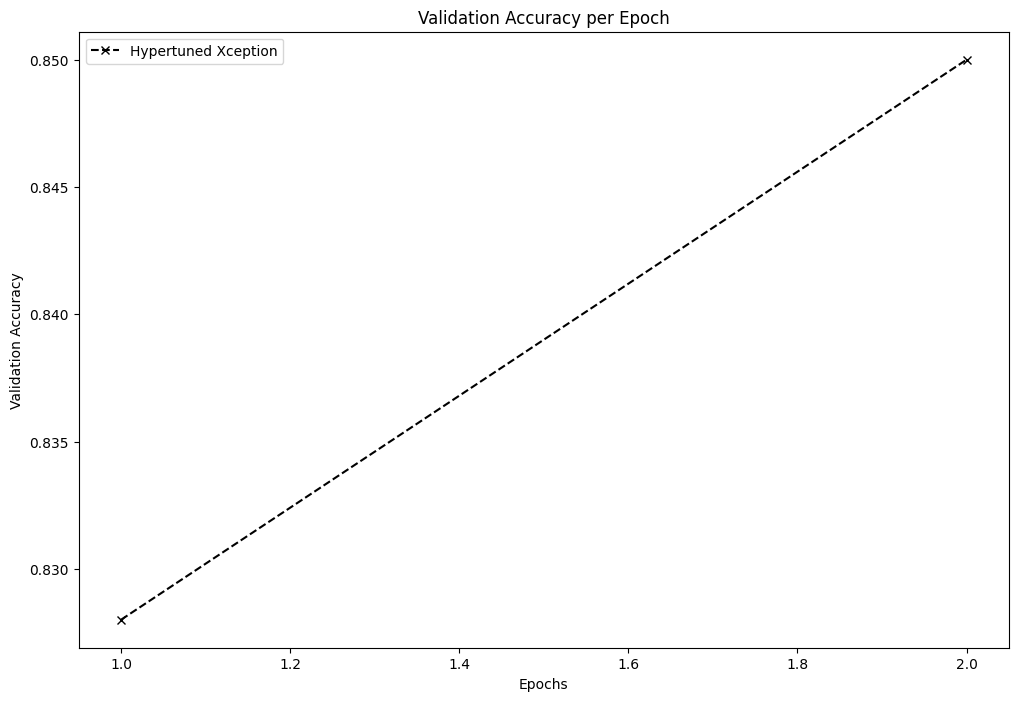

In [ ]:

import matplotlib.pyplot as plt

# Example data (replace these with actual validation accuracy lists)
epochs = range(1, len(val_accuracy_hypertuned_xception) + 1)

# Create the plot
plt.figure(figsize=(12, 8))

# plt.plot(epochs, val_accuracy_cnn, 'm-o', label='Basic CNN')
# plt.plot(epochs, val_accuracy_densenet, 'r-', label='DenseNet121')
# plt.plot(epochs, val_accuracy_xception, 'b-', label='Xception')
# plt.plot(epochs, val_accuracy_efficientNet, 'g-', label='EfficientNetB4')
plt.plot(epochs, val_accuracy_hypertuned_xception, 'k--x', label='Hypertuned Xception')

# Add titles and labels
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison.png')
plt.show()


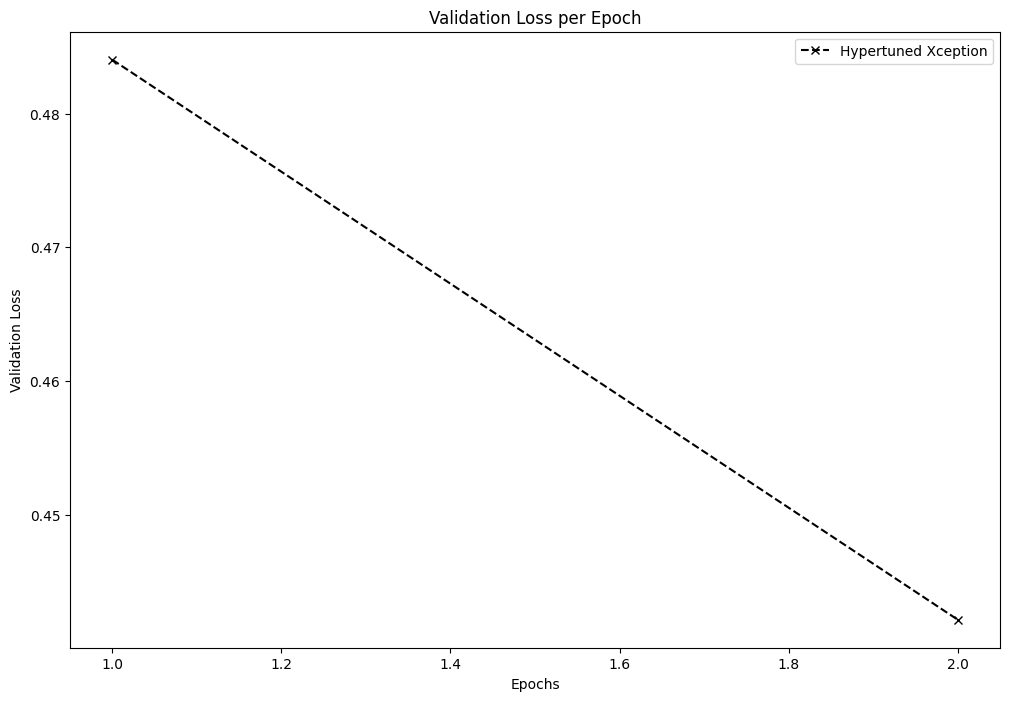

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace these with actual validation loss lists)
epochs = range(1, len(val_loss_hypertuned_xception) + 1)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot validation loss for each model
# plt.plot(epochs, val_loss_cnn, 'm-o', label='Basic CNN')
# plt.plot(epochs, val_loss_densenet, 'r--s', label='DenseNet121')
# plt.plot(epochs, val_loss_xception, 'b-.^', label='Xception')
# plt.plot(epochs, val_loss_efficientNet, 'g:.', label='EfficientNetB4')
plt.plot(epochs, val_loss_hypertuned_xception, 'k--x', label='Hypertuned Xception')  # Dashed black line with x markers

# Add titles and labels
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison_loss.png')
plt.show()
